In [2]:
from gymnasium import Env
from gymnasium.spaces.box import Box
import numpy as np
import random
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.noise import NormalActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import os
import matplotlib.pyplot as plt
import scipy.io
import scipy
import numpy as np
import pickle
import warnings
import math
from typing import Callable
warnings.filterwarnings("ignore")

# Siguientes pasos
* Si funciona:
    * Variar situación inicial
    * Añadir el crash
    * Cambiar reward a corriente
* Si no funciona:
    * Añadir sigmoide al final
    * Cambiar reward a corriente
    * Añadir el crash

In [21]:
class Bobina():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 200, airgap = 23):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    mat = scipy.io.loadmat('./coil/hems.mat')
    self.hems = mat["hems"][0][0]
    self.airgaps = self.hems[0][0]
    self.currents = self.hems[1][0]
    self.force_vertical = pickle.load(open("./coil/mlp_vertical.pkl", 'rb'))
    self.flux = self.hems[3]
    self.force_horizontal = self.hems[4]
    self.inductance = pickle.load(open("./coil/rf_inductance.pkl", 'rb'))
    self.resistance = self.hems[6][0][0]
    self.min_distance = self.airgaps[0]
    self.max_distance = self.airgaps[-1]
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = []

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    current = self.integral(self.steps_RL, h = 0.001)                          
    return current                                                  

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    return float(self.inductance.predict(np.array([[airgap, current]]))[0])

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I


  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    return float(self.force_vertical.predict(np.array([[airgap, current]])))    


  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 19.5), np.float32(self.current)), self.crash
class BobinaEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just one coil.
  """
  def __init__(self, masa_pod = 200, airgap = 10, duration = 10):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100]), high = np.array([50]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([10, -np.inf, -10, -45]), high = np.array([23, np.inf, 10, 45]), dtype=np.float32)
    # Initial parameters
    self.state = np.array([airgap, 0, airgap - 19.5, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.bobina = Bobina(masa_pod = self.masa_pod, airgap = self.airgapinicial)
    self.steps = []
    self.airgap = airgap
    self.distancia = 0
    self.velocidad = 0
    self.current = 0


  def step(self, action):
    # Apply action
    self.state, self.crash = self.bobina.step(action[0])
    self.airgap, self.velocidad, self.distancia, self.current = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    if self.airgap >= 23: reward = -5000
    elif self.airgap <= 10: reward = -5000
    else: reward = -abs(self.current)

    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    if self.crash:
      reward = - 50000
      terminated = True
    else:
      terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes"):
    # create data
    x = list(range(0,len(self.steps)))
    y = [step[0] for step in self.steps]
    objective = [19.5]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

    plt.plot(x, y, label = "States")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.choice([19.5])
    self.state = self.airgapinicial
    self.bobina = Bobina(masa_pod = self.masa_pod, airgap = airgap)
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [22]:
run = wandb.init(
    project="1gdlppo",
    sync_tensorboard=True,
    monitor_gym=True,
)

# Create log dir
log_dir = "1gdlppo/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BobinaEnv( airgap = 19.5,duration = 4 )
env = Monitor(env, log_dir)

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

model = PPO("MlpPolicy", env,learning_rate = linear_schedule(0.001), n_steps = 80000, batch_size=512, ent_coef=0.2, seed = 42, verbose=1, tensorboard_log=log_dir)

global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,▁▁▁▂▂▄▆▇████████████████████████████████
time/fps,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▅▅▆▇███▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▇▇
train/approx_kl,▃▃▃▁▂▁▆▅▁▃▃▁▂▂▂▂▂▁▁▂▁▂▃▁▆█▇▆▄▇▆▃▅▆▄▅▆▃▅▅
train/clip_fraction,▅▅▅▂▂▂█▆▁▄▄▂▂▃▃▂▂▂▁▂▁▂▄▁▆▇▇▆▄▇▇▄▆▆▅▅▆▄▆▆
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,█████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
train/explained_variance,▁▂▃▅▆▆▆▆███████████████▅████████████████
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,██▇▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Using cpu device
Wrapping the env in a DummyVecEnv.


In [18]:
import torch
model.policy.action_net = torch.nn.Sequential(
    torch.nn.Linear(in_features=64, out_features=1, bias=True),
    torch.nn.Sigmoid()
)

In [19]:
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(
    save_freq=10000, save_path=log_dir, name_prefix="rl_ppo_1gdlobj"
)

# Train the agent
model.learn(total_timesteps=20000000,
    callback=[
        checkpoint_callback,
        WandbCallback(
            gradient_save_freq=10000,
            model_save_path=f"models/ppocuadratico",
            model_save_freq=10000,
            verbose=2,
        ),
    ],
)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to 1gdlppo/PPO_13
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4e+03     |
|    ep_rew_mean     | -1.89e+07 |
| time/              |           |
|    fps             | 131       |
|    iterations      | 1         |
|    time_elapsed    | 607       |
|    total_timesteps | 80000     |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4e+03         |
|    ep_rew_mean          | -1.89e+07     |
| time/                   |               |
|    fps                  | 133           |
|    iterations           | 2             |
|    time_elapsed         | 1202          |
|    total_timesteps      | 160000        |
| train/                  |               |
|    approx_kl            | 0.00052105833 |
|    clip_fraction        | 0.000551      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.43         |
|    exp

KeyboardInterrupt: 

: 

In [12]:
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Time predict 2.038398504257202
Time model 28.249844074249268
Episode reward -345011.91880669864


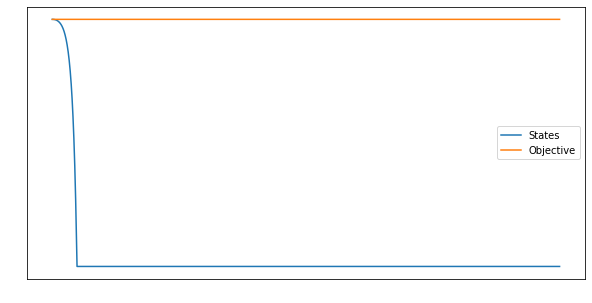

Time predict 2.0703630447387695
Time model 28.64287042617798
Episode reward -345011.91880669864


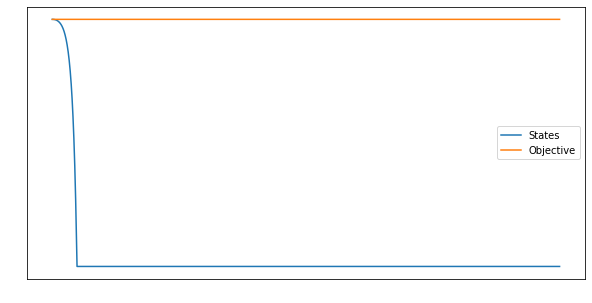

Time predict 1.9565157890319824
Time model 28.91672706604004
Episode reward -345011.91880669864


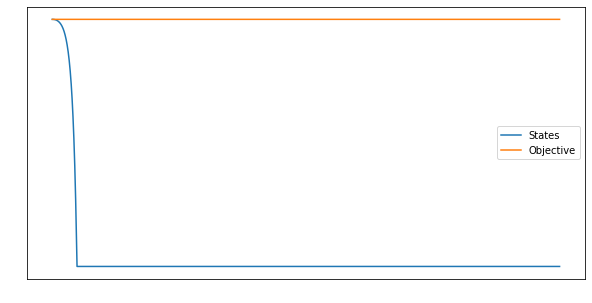

Time predict 2.0105221271514893
Time model 28.061734914779663
Episode reward -345011.91880669864


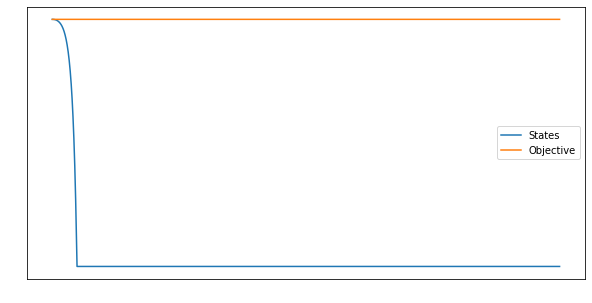

Time predict 2.001551866531372
Time model 27.71768879890442
Episode reward -345011.91880669864


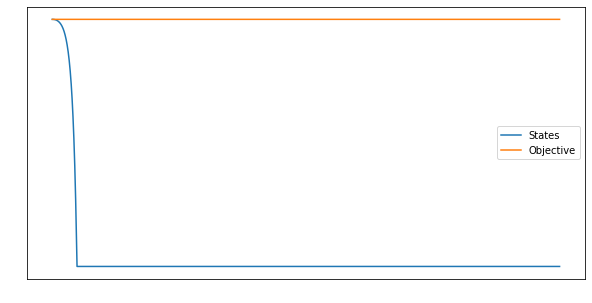

In [14]:
import numpy as np
import torch as th
import time

MODEL_PATH = f"models/ppocuadratico/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 4)

# Load the trained agent
model = PPO.load(MODEL_PATH, env=env)

# Evaluate the agent
for i in range(5):
    obs, seed = env.reset()
    done = False
    episode_reward = 0
    velocidad = 0
    current = 0
    observations = []
    noises = []
    error = obs -19.5
    timepredict = 0
    timemodel = 0
    while not done:
        #noise = random.uniform(-1, 1)
        #obs = obs + noise
        observations.append(obs)
        #noises.append(noise)
        t1 = time.time()
        action, _states = model.predict(np.array([obs, velocidad, error, current]), deterministic=True)
        t2 = time.time()
        #print(action)
        #if env.airgap > 10.1: action = max(action, [-50])
        #print(action)
        t3 = time.time()
        state, reward, terminated, truncated, info = env.step(np.array(action))
        t4 = time.time()
        obs, velocidad, error, current = state
        done = truncated or terminated
        episode_reward += reward
        timepredict += t2 - t1
        timemodel += t4 - t3
        noises.append(action)
    print("Time predict", timepredict)
    print("Time model", timemodel)
    print("Episode reward", episode_reward)
    #print(noises)
    env.render("yes")